### Importation des librairies

In [117]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
#Traitement des messages d'erreur :
warnings.filterwarnings('ignore')
import timeit
# Importation du package pour le SMOTE
from sklearn.pipeline import make_pipeline
import math
#Librairie pour importer des variables d'un autre notebook
import pickle
#Librairie pour les métriques avec GridSearch
import sklearn.metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report, confusion_matrix
#Librairie pour la régression logistique
from sklearn.linear_model import LogisticRegression
#Librairie pour le modèle LIGHTGBM
from lightgbm import LGBMClassifier
#Librairie pour XGBoostClassifier
from xgboost import XGBClassifier
#Librairie pour le Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier


### Fonctions utilisées dans le notebook

In [118]:
#Création d'une fonction pour utiliser chaque modèle d'entrainement et afficher les différents résultats de métriques

def training_model (name_of_model, parameters):
    """Fonction afin d'entrainer différents modèle en retournant les résultats de différents métriques"""
    grid = GridSearchCV(name_of_model,
                       parameters,
                       #Cross validation
                       cv=5, #Permet d'entrainer le modèle en le découpant en folds, ici on entrainte 5 fois le modèle 
                       scoring=accuracy_score,
                       n_jobs=-1, #Permet d'obliger le modèle à travailler sur tous les CPU du PC
                       refit='accuracy_score', #Permet de réajuster un estimateur en utilisant les meilleurs paramètres trouvés sur l'ensemble de données
                       return_train_score=True, #Permet de renvoyer les scores de train
                       verbose=1) #Permet de définir la quantité d'infos renvoyer par GridSearch pendant son déroulement
                                             
    model = make_pipeline(StandardScaler(with_mean=False), grid)
    
    start_time = timeit.default_timer()
    model.fit(X_train_res, y_train_res)
    elapsed = timeit.default_timer() - start_time
    elapsed = np.round(elapsed, 3)

    print("Le temps d'entrainement du modèle est de {0:.3f} millisecondes".format(elapsed), "\n")

   # "precision": "accuracy_score", "f1": "f1_score", "recall": "recall_score",
   #                             "roc_auc": "roc_auc_score"

    #Affichage des meilleurs paramètres
    best_params = grid.best_params_
    
    #Affichage des meilleurs métriques :
    best_estimators = grid.best_estimator_
    #best_scores = grid.best_estimator_.score(X_test_transformed, y_test),
    
    print("Les meilleurs paramètres du modèle sont : ", best_params)
    #Affichage des résultats
    class_report = classification_report(y_test, model.predict(X_test_transformed))
    print(class_report)
    confusion_mat(y_test, model.predict(X_test_transformed))
    AUC_graph(y_test, model.predict(X_test_transformed), model.predict_proba(X_test_transformed)[:,1])
    
    
    accuracy = accuracy_score(y_test, model.predict(X_test_transformed))
    print("Le score accuracy du modèle est de : ", accuracy)
    #auc_score = roc_auc_score(y_test, model.predict(X_test_transformed))
    #print("Le score AUC du modèle est de : ", auc_score)
    f1 = f1_score(y_test, model.predict(X_test_transformed))
    print("Le score f1 du modèle pour la classe 1 est de : ", f1)
    precision = precision_score(y_test, model.predict(X_test_transformed))
    print("Le score precision du modèle pour la classe 1 est de : ", precision)
    recall = recall_score(y_test, model.predict(X_test_transformed))
    print("Le score recall du modèle pour la classe 1 est de : ", recall)

In [119]:
#Fonction pour affiche la matrice de confusion
def confusion_mat(y_true, y_pred):
    """Fonction pour calculer et afficher une matrice de conusion"""
    conf_mat = confusion_matrix(y_true, y_pred)
    fig = plt.figure(figsize=(10,10))
    group_names = ['Vrais Négatifs', 'Faux Positifs', 'Faux Négatifs', 'Vrais Positifs']
    group_counts = ["{0:0.0f}".format(value) for value in conf_mat.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in conf_mat.flatten()/np.sum(conf_mat)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(conf_mat, annot=labels, fmt="", cmap='Blues')
    
#Fonction pour afficher la courbe AUC
def AUC_graph(y_true, y_pred, y_pred_proba):
    """Fonction pour calculer et afficher la courbe AUC """
    dummy_class_report = classification_report(y_true, y_pred)
    model_roc_auc_score = roc_auc_score(y_test, y_pred_proba)
    fig = plt.figure(figsize=(10,10))
    false_positive, true_positive, _ = roc_curve(y_true, y_pred_proba)
    plt.plot(false_positive, true_positive, label = "AUC = %0.2f" %model_roc_auc_score)
    plt.plot([0, 1], [0, 1],linestyle='--')
    plt.xlabel("Taux de Faux Positifs")
    plt.ylabel("Taux de Vrais Positifs")
    plt.title("Courbe de l'AUC")
    plt.legend(loc = 'upper left')
    plt.show()
    return model_roc_auc_score, dummy_class_report

### Lecture des datasets

In [120]:
path = 'Projet_7/'
X_train_res = pd.read_csv(path + "X_train_res.csv")
X_test_transformed = pd.read_csv(path + "X_test_transformed.csv")
y_train_res = pd.read_csv(path + "y_train_res.csv")
y_test = pd.read_csv(path + "y_test.csv")

In [121]:
#Import des résultats du modèle DummyClassifier
fichierSauvegarde = open("donnees","rb")
dummy_class_auc_score = pickle.load(fichierSauvegarde)
dummy_class_report = pickle.load(fichierSauvegarde)
fichierSauvegarde.close()
print(dummy_class_auc_score)
print(dummy_class_report)

0.5
              precision    recall  f1-score   support

           0       0.92      0.50      0.65     56445
           1       0.08      0.49      0.14      5058

    accuracy                           0.50     61503
   macro avg       0.50      0.50      0.39     61503
weighted avg       0.85      0.50      0.60     61503



On peut voir que le modèle DummyClassifier est peu performant avec un score AUC au minimum qui est de 0,50 et un score accuracy de 0,50. Il nous servira de modèle de base afin d'avoir un point de comparaison avec les autres modèles entrainés. En effet nous prenons comme métrique l'accuracy car nous sommes en présence d'un nombre plus important de Vrais Positifs et Vrais Négatifs que de Faux Négatifs et Faux Positifs (si nous avions été dans le cas contraire, nous aurions pris le score f1 comme métrique)

### Test des différents modèles de régression linéaire

### Régression logistique

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Le temps d'entrainement du modèle est de 36.209 millisecondes 

Les meilleurs paramètres du modèle sont :  {'C': 0.001, 'fit_intercept': True, 'penalty': 'l2'}
              precision    recall  f1-score   support

           0       0.95      0.64      0.77     56445
           1       0.14      0.66      0.23      5058

    accuracy                           0.65     61503
   macro avg       0.55      0.65      0.50     61503
weighted avg       0.89      0.65      0.73     61503



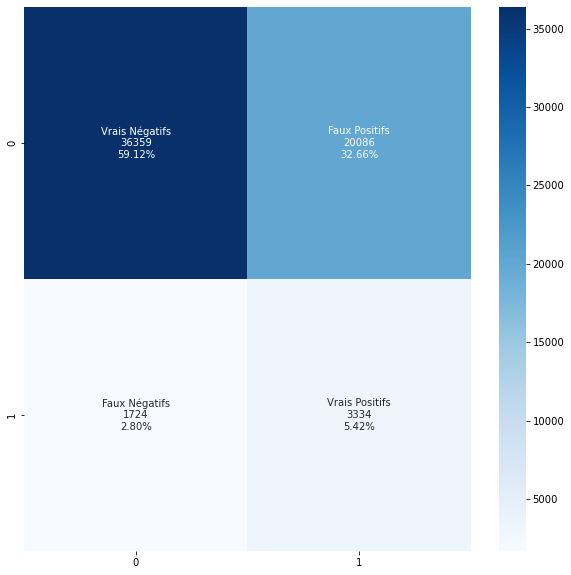

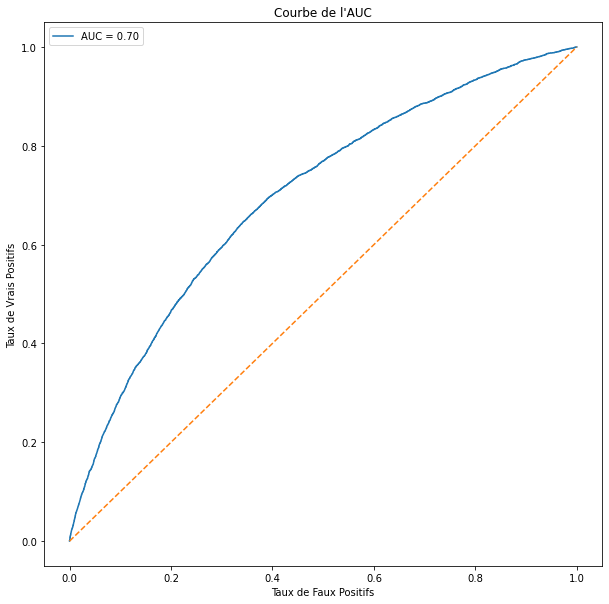

Le score accuracy du modèle est de :  0.6453831520413639
Le score AUC du modèle est de :  0.651651493748783
Le score f1 du modèle pour la classe 1 est de :  0.2341456562960882
Le score precision du modèle pour la classe 1 est de :  0.14235695986336463
Le score recall du modèle pour la classe 1 est de :  0.6591538157374456


In [122]:
#Regression logistique

#lr_parameters = {"penalty": ['l1', 'l2', 'elasticnet', None], "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
#                 "fit_intercept": [True, False]}
#lr_parameters = {"penalty": ['l2'], "C": [0.001], "fit_intercept": [True, False]}
lr_parameters = {"penalty": ['l2'], "C": [0.001], "fit_intercept": [True]}

lr = LogisticRegression()

training_results_lr = training_model(lr, lr_parameters)

### LIGHTGBM

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Le temps d'entrainement du modèle est de 28.154 millisecondes 

Les meilleurs paramètres du modèle sont :  {'colsample_bytree': 0.1, 'num_leaves': 5}
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56445
           1       0.34      0.00      0.01      5058

    accuracy                           0.92     61503
   macro avg       0.63      0.50      0.48     61503
weighted avg       0.87      0.92      0.88     61503



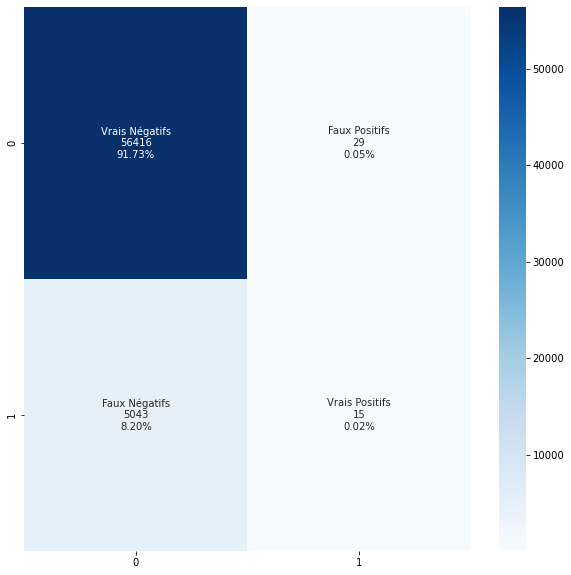

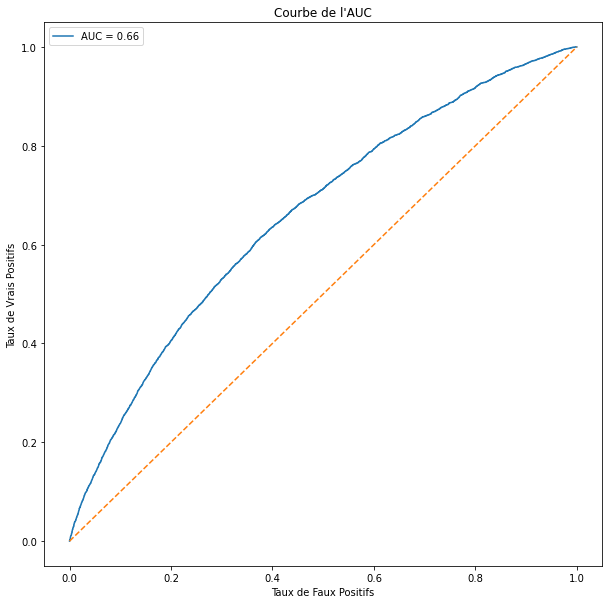

Le score accuracy du modèle est de :  0.9175324780904996
Le score AUC du modèle est de :  0.5012259122901422
Le score f1 du modèle pour la classe 1 est de :  0.005880047040376324
Le score precision du modèle pour la classe 1 est de :  0.3409090909090909
Le score recall du modèle pour la classe 1 est de :  0.0029655990510083037


In [123]:
#LIGHTGBM (Gradient boosting methods)

#lgbm_parameters = {'num_leaves': [5, 50, 100, 150], 'colsample_bytree': [0.1, 0.5, 1]}
lgbm_parameters = {'num_leaves': [5], 'colsample_bytree': [0.1]}

lgbm = LGBMClassifier()

training_results_lrridge = training_model(lgbm, lgbm_parameters)

### XG Boost

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Le temps d'entrainement du modèle est de 48.599 millisecondes 

Les meilleurs paramètres du modèle sont :  {'colsample_bytree': 0.1, 'gamma': 0.1, 'max_depth': 1}
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     56445
           1       0.20      0.14      0.17      5058

    accuracy                           0.88     61503
   macro avg       0.56      0.55      0.55     61503
weighted avg       0.87      0.88      0.87     61503



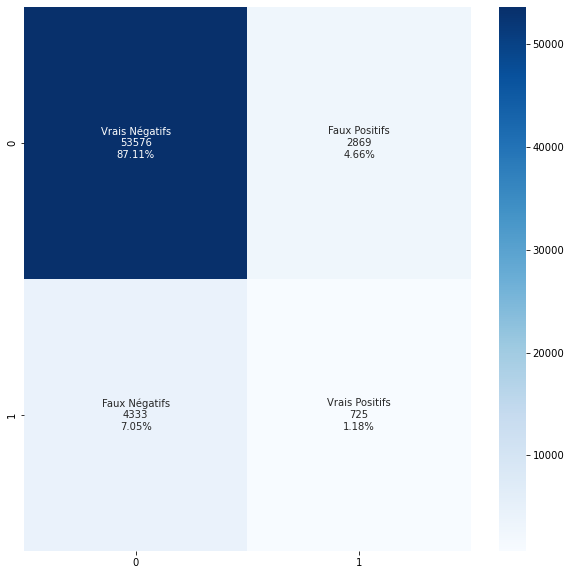

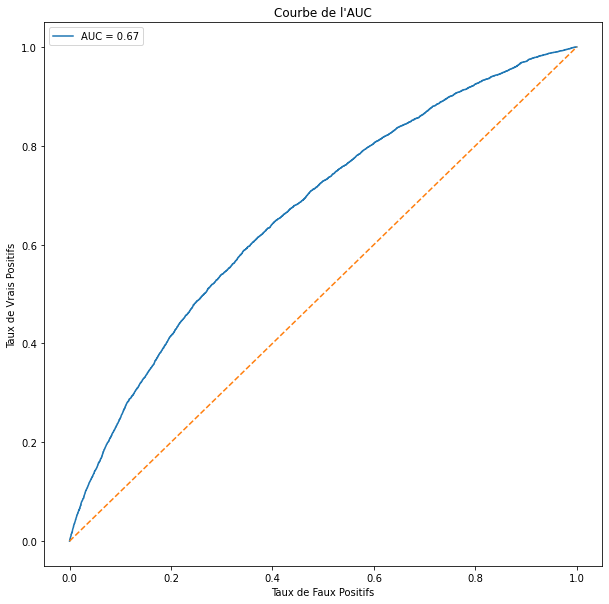

Le score accuracy du modèle est de :  0.8829000211371802
Le score AUC du modèle est de :  0.5462545237929363
Le score f1 du modèle pour la classe 1 est de :  0.16759130836800737
Le score precision du modèle pour la classe 1 est de :  0.20172509738452976
Le score recall du modèle pour la classe 1 est de :  0.14333728746540134


In [128]:
#XGBOOST

#xgb_parameters = {'colsample_bytree': [0.1, 0.5, 1], 'gamma': [0.3],
#                  'max_depth': [5]}
#xgb_parameters = {'colsample_bytree': [0.1], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5],
#                  'max_depth': [5]}
#xgb_parameters = {'colsample_bytree': [0.1], 'gamma': [0.1],
#                  'max_depth': [1, 3, 5, 7, 10]}
xgb_parameters = {'colsample_bytree': [0.1], 'gamma': [0.1], 'max_depth': [1]}

xgb = XGBClassifier()

training_results_xgb = training_model(xgb, xgb_parameters)

### Random Forest

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Le temps d'entrainement du modèle est de 43.287 millisecondes 

Les meilleurs paramètres du modèle sont :  {'max_depth': 10, 'max_features': 'auto', 'n_estimators': 10}
              precision    recall  f1-score   support

           0       0.92      0.96      0.94     56445
           1       0.21      0.12      0.15      5058

    accuracy                           0.89     61503
   macro avg       0.57      0.54      0.55     61503
weighted avg       0.87      0.89      0.88     61503



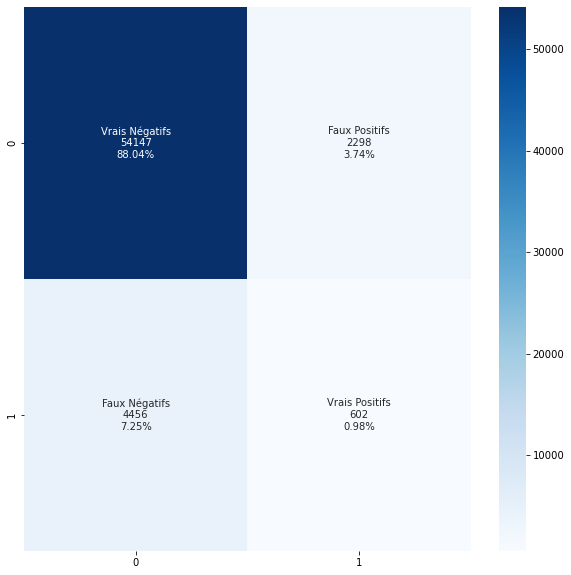

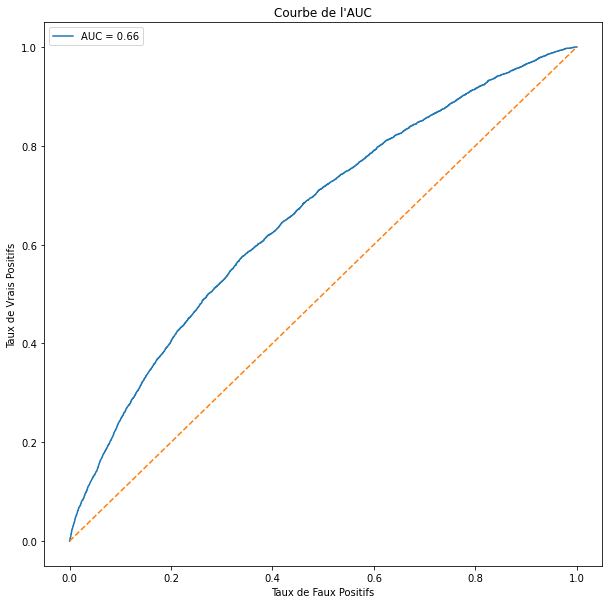

Le score accuracy du modèle est de :  0.8901842186560005
Le score AUC du modèle est de :  0.539153588766272
Le score f1 du modèle pour la classe 1 est de :  0.1512942950490073
Le score precision du modèle pour la classe 1 est de :  0.20758620689655172
Le score recall du modèle pour la classe 1 est de :  0.11901937524713326


In [125]:
#Random Forest

#rf_parameters = {'n_estimators': [10, 20, 30, 40], 'max_depth': [30],
#                 'max_features': ['auto', 'sqrt']}
#rf_parameters = {'n_estimators': [10], 'max_depth': [10, 20, 30, 40, 50],
#                 'max_features': ['auto']}
rf_parameters = {'n_estimators': [10], 'max_depth': [10], 'max_features': ['auto']}

rf = RandomForestClassifier()

training_results_rf = training_model(rf, rf_parameters)

### Conclusion

Nous avons donc les résultats suivants pour les 4 modèles entrainés :
- DummyClassifier : Temps d'entrainement = NC; AUC = 0,50; Accuracy = 0,50         
- LogisticRegression : Temps d'entrainement = 36,2ms; AUC = 0,70; Accuracy = 0,65
- LIGHTGBM : Temps d'entrainement = 28,2ms; AUC = 0,66; Accuracy = 0,92
- XGBoostClassifier : Temps d'entrainement = 46,6ms; AUC = 0,67; Accuracy = 0,88
- RandomForestClassifier : Temps d'entrainement = 43,3ms; AUC = 0,66; Accuracy = 0,89

Après une première analyse des résultats, la différence sur les temps d'entrainement est minime et donc cette mesure ne sera pas prise en compte.
Sur les 5 modèles nous avons des AUC et accuracy proches pour 3 modèles qui sont le LIGHTGBM, XGBOOSTCLASSIFIER et RANDOMFORESTCLASSIFIER.
Nous les conservons donc pour notre choix final.
Pour les départager nous allons comparer les résultats concernant les taux de Faux Positifs et Faux Négatifs.

Nous avons donc les résultats suivants pour les 3 modèles restants :
- LIGHTGBM : Taux Faux Positifs = 0,05 %; Taux Faux Négatif = 8,20 %
- XGBoostClassifier : Taux Faux Positifs = 4,66 %; Taux Faux Négatif = 7,05 %
- RandomForestClassifier : Taux Faux Positifs = 3,74 %; Taux Faux Négatif = 7,25 %

Notre choix final va se porter sur le modèle avec le plus faible taux de Faux Négatif. 
En effet, cette catégorie représente des personnes pour lesquelles nous octroyons un crédit alors qu'ils ne sont pas en capacité de le rembourser conctrairement aux Faux Positifs qui concerne les clients qui eux seront en capacité de rembourser mais pour lesquelles nous aurons refusé l'octroi du prêt.

Notre choix de modèle final sera donc le modèle XGBoostClassifier.
Les hyprparamètres à privilégier suite à la fonction Grid Search sont :
- colsample_bytree : 0.1
- gamma : 0.1
- max_depth : 1

Nous allons dans le prochain notebook, voir comment améliorer les résultats du modèles et définir features final du dataset à conserver.